In [1]:
from scipy.integrate import odeint
import math 
import numpy as np
import matplotlib.pyplot as plt
import theano
%matplotlib inline

theano.config.exception_verbosity= 'high'
THEANO_FLAGS='optimizer=fast_compile'

#  Fitzhugh Nagumo model in oscillatory mode
In this example we will use PyMC3 to infer the parameters of the Fitzhugh-Nagumo oscillator. It is a simple model that 
generates action potentials. The model is describes as:

\begin{align}
\frac{dV}{dt}&=(V - \frac{V^3}{3} + R)c\\
\frac{dR}{dt}&=\frac{-(V-a+bR)}{c},
\end{align}
where $a$, $b$, $c$ are the model parameters.

We start by defining our ODE solver. In this case we will be using scipy odeint. However, note that we can also wrapp any other solver written in say C++. The point I am trying to drive home is that we are free to call up any model solver as long as it is available in python.

In [2]:
def model_deriv(y, t, param):
    #Define parameters
    a,b,c=param
    
    #define states
    V,R=y
    #define derivatives
    dV_dt=(V-((V**3)/3) +R)*c
    dR_dt=-(V-a+b*R)/c
    return dV_dt,dR_dt
    
def model_sol(param):
    
    y0 = [-1,1]
    time = np.linspace(0, 20, 200)
    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

#  Generate an artificial dataset

Having defined our model solver and forward solution, we can generate some synthetic data $Y$. We solve the model between [0,20] with 200 equispaced time points and add Gaussian noise with $\sigma=0.5$.

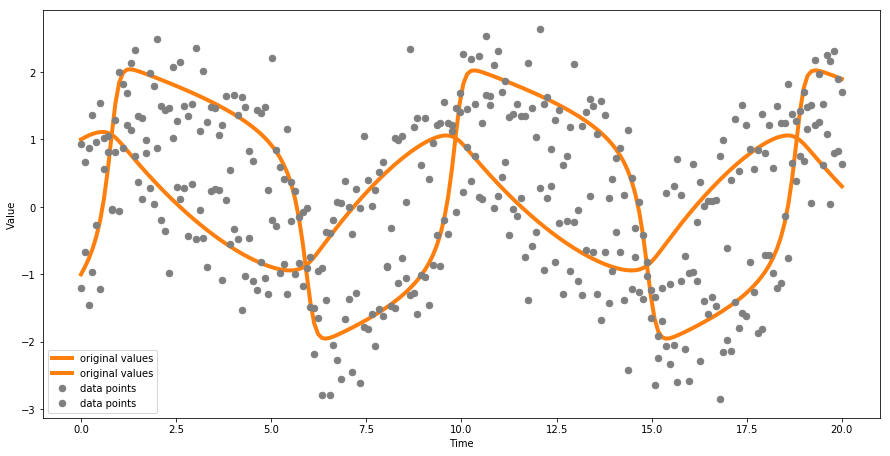

In [3]:
times = np.linspace(0, 20, 200)
sigma=0.5
sol=model_sol([0.2,0.2,3.])
Y=sol+np.random.randn(200,2)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

# Bayesian inference for ODEs

We have defined the observed data as $Y$. These are the experimental observations which are artificially corrupted by Gaussian noise in this example. The likelihood is $p(Y|\theta)=\prod_{i=1}^T\mathcal{N}(Y(t);X(t,\theta),\sigma^2\mathbb{I})$, where we have collected the state vector $X(t,\theta)=[V(t,\theta),R(t,\theta)]$ across each time point $t=1,\ldots,T$. Note that the parameter $\theta=(a,b,c)$ dependancy is explicitely written here. However, for any non-linear ODE we have to numerically solve it to obtain the parametric response. Now using the Bayes theorem we can combine the likelihood with a prior $p(\theta)$ to obtain the posterior as:
$$ p(\theta|Y)=\frac{1}{Z}p(Y|\theta)p(\theta),$$ where $Z=p(Y)=\int p(Y|\theta)p(\theta)d\theta$ is the marginal likelihood (useful for model selection) which is intractable. We would sample from this posterior using the powerful transitional Markov chain Monte Carlo (SMC in PyMC3) sampler. This sampler is very close in spirit to the SMC sampler proposed by Del Moral and Doucet.

In order to sample we need to define the generative model. This is extremely easy when using PyMC3. The difficult bit is how to embed the forward solution within a PyMC3 program. The difficult approach is writing a custom solver in Theano (on which PyMC3 is built). However, there is an easy way around this issue. Theano lets us define a sort of black box function, called the `as_op`, as a wrapper on existing Python code. We loose the ability to differentiate this function but if we use a sampler such as Metropolis or the SMC then we don't need any gradient calculation. This is what we turn to next.

#  Define a black-box op using Theano @as_op

This is perhaps the most important part of this example. Here we are defining a custom Theano as_op. Note that we are 
wrapping up the forward solution of our model as an as_op. Thus we tell Theano that we have three parameters each 
being a Theano scalar. The output then is a Theano matrix whose colums are the state vectors.

In [4]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dmatrix])
def Fitzhugh_ode_sol(param1,param2,param3):
    
    param=[param1,param2,param3]
    sol=model_sol(param)
    
    return sol


#  The probabilistic model: A lego approach

Next we define the probabilistic program that is the generative model where we define the priors and the likelihood. The likelihood is a multivariate Normal distribution. The priors are set as follows:
$a\sim \mathcal{\Gamma}(2,1)$, $b\sim \mathcal{N}(0,1)$ and $c\sim \mathcal{U}(0,10)$. In this example we will be estimating the noise standard deviation and thus we put the following prior: $\sigma\sim \mathcal{N}(0,1)$. 

In [5]:
import pymc3 as pm
from pymc3.step_methods import smc
from tempfile import mkdtemp
from scipy import optimize

theano.config.floatX = 'float64'
FN_model = pm.Model()
n_steps = 20 # Number of MCMC steps for each particle, for best performance don't specify this
n_chains = 100 # Number of particles (chains), in real problems use more chains

with FN_model:

    # Priors for unknown model parameters
    
    a = pm.Gamma('a', alpha=2, beta=1, transform=None)
    b = pm.Normal('b', mu=0, sd=1)
    c = pm.Uniform('c', lower=0, upper=10, transform=None)
    
    sigma = pm.Normal('sigma', mu=0, sd=1)


    # Forward model
    
    mu = Fitzhugh_ode_sol(a,b,c)
    
    # Likelihood (sampling distribution) of observations
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

    
    test_folder = mkdtemp(prefix='SMC_TEST')
    
     # Initial points for each of the chains
    startsmc=[{'a':np.random.uniform(0,15,1),'b':np.random.uniform(0,15,1),
            'c':np.random.uniform(2.5,3.5,1),'sigma':np.random.uniform(0,2)} for _ in range(n_chains)]
    
    # Call SMC sampler
    trace = smc.sample_smc(n_steps=n_steps,n_chains=n_chains,start=startsmc,progressbar=True,
                           homepath=test_folder,stage=0,tune_interval=5,random_seed=20)

/home/sanosh/pymc3/pymc3/step_methods/smc.py:491: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
/home/sanosh/pymc3/pymc3/step_methods/smc.py:118: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
 28%|██▊       | 28/100 [00:01<00:05, 12.79it/s]/usr/local/lib/python2.7/dist-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


#  Visualise the posterior marginals

We inspect first the traceplots to see whether the chains are mixing well enough.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7c81d8d50>,
      dtype=object)

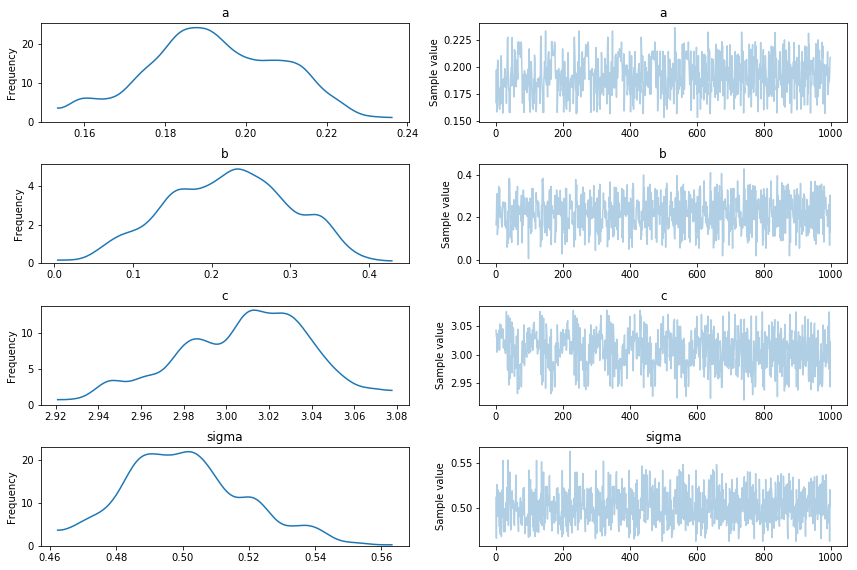

In [6]:
pm.traceplot(trace)

Nice visualisations support in-built

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7c51e3fd0>,
      dtype=object)

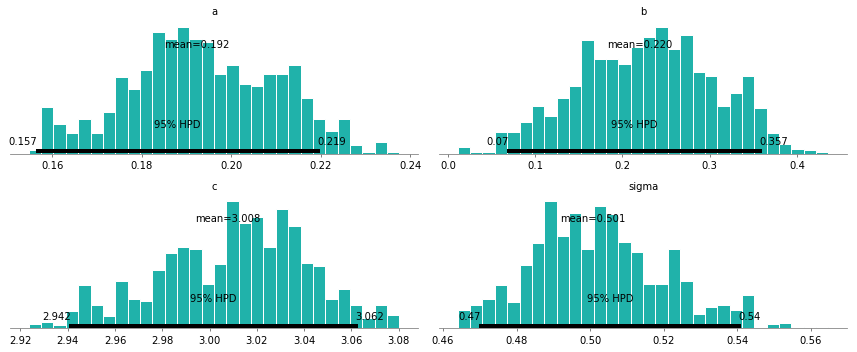

In [7]:
pm.plot_posterior(trace,color='LightSeaGreen')

#  PyMC3 backend as Dataframes

We can use PyMC3 backend object that represents the chain(s) and use some pandas magic

In [9]:
import pandas as pd

results=[pm.summary(trace, ['a']),pm.summary(trace, ['b']),pm.summary(trace, ['c'])\
        ,pm.summary(trace, ['sigma'])]
results=pd.concat(results)

results['True values'] = pd.Series(np.array([0.2,0.2,3.0,0.5]), index=results.index)
results

,mean,sd,mc_error,hpd_2.5,hpd_97.5,True values
a,0.192289,0.016632,0.000643,0.156710,0.219304,0.2
b,0.220475,0.078029,0.002261,0.070190,0.357464,0.2
c,3.007770,0.031279,0.001392,2.941547,3.061812,3.0
sigma,0.500807,0.018102,0.000552,0.470287,0.540433,0.5


#  Posterior predictive plots

In [10]:
params=np.array([trace.get_values('a'),trace.get_values('b'),trace.get_values('c')]).T
params.shape

(1000, 3)

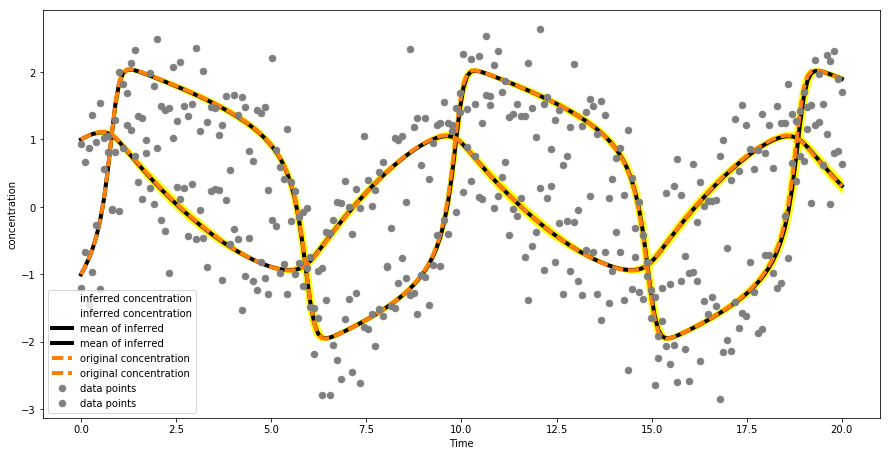

In [11]:
new_values = []
for ind in range(len(params)):
    ppc_sol=model_sol(params[ind])
    new_values.append(ppc_sol)
new_values = np.array(new_values)
mean_values = np.mean(new_values, axis=0)
new_values.shape
plt.figure(figsize=(15, 7.5))
plt.plot(times, new_values[0], color='yellow', alpha=0.05, label='inferred concentration')
for v in new_values[1:]:
    plt.plot(times, v, color='yellow', alpha=0.05)
plt.plot(times, mean_values, color='black', lw=4, label='mean of inferred')
plt.plot(times, sol, '--', color='#ff7f0e', lw=4, label='original concentration')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('concentration')


#  Remember we get the marginal likelihood for free

In [ ]:
FN_model.marginal_likelihood